# CASA0002_Urban simulation Assignment

<div style="float:left">
            <h1 style="width:450px">Code Part 2</h1>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

Assignment requirements [here](https://github.com/yiyansun/urbsim/blob/main/accessment/AssessUrbanSim2024.pdf)

Marking scheme [here](https://github.com/yiyansun/urbsim/blob/main/accessment/UrbanSim_Marking_Scheme.pdf)

Code is available [here](https://github.com/yiyansun/urbsim/blob/main/accessment/Part1.ipynb)

[Data](https://github.com/yiyansun/urbsim/tree/main/accessment/data) : London underground graph and london_flow.csv

In [1]:
import requests
import urllib.request
import io

import pandas as pd
import numpy as np
import math
import geopandas as gpd
import networkx as nx
import folium
import statsmodels.api as sm
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from math import sqrt
import statsmodels.formula.api as smf
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Part 2: Spatial Interaction models

> For this section, you will be given a “symbolic” population and the number of jobs for the stations in 
the underground. You will also be given the number of people that commute from one station to 
another, through an OD matrix. 

In [2]:
# read data
url = "https://github.com/yiyansun/urbsim/raw/main/assessment/data/london_tubenetwork.graphml"
with urllib.request.urlopen(url) as response:
    content = response.read().decode('utf-8')
file = io.StringIO(content)

# Read the GraphML content and create the graph
G = nx.read_graphml(file)

# Check the type of G
print(type(G))

<class 'networkx.classes.graph.Graph'>


In [3]:

london_flows = pd.read_csv('https://raw.githubusercontent.com/yiyansun/urbsim/main/assessment/data/london_flows.csv')
london_flows.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [4]:
london_flows = london_flows[london_flows.population != 0]
london_flows = london_flows[london_flows.distance != 0]
london_flows = london_flows[london_flows.jobs != 0]

for col in ["population", "jobs", "distance"]:
    london_flows[f"log_{col}"] = np.log(london_flows[col])
london_flows.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274


In [5]:
flows = london_flows.copy()

## III. Models and calibration


### III.1.  Spatial interaction models: 8


> Briefly introduce the spatial interaction models covered in the lectures using equations and 
defining the terms, taking particular care in explaining the role of the parameters. 


- unconstrained model
- production constrained model
- attraction constrained model
- production-attraction constrained

In [6]:
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(np.sqrt(res.mean()), 3)
    
    return RMSE

- unconstrained model

- - inverse power

In [7]:
f_un=london_flows.copy()

formula_unconstrain_inv_power = 'flows ~ log_population + log_jobs + log_distance'
#run the regression
uncosim_inv_power = smf.glm(formula = formula_unconstrain_inv_power, 
                    data=f_un, 
                    family=sm.families.Poisson()).fit()
print('inverse power')
print(uncosim_inv_power.summary())

inverse power
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61409
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2785e+06
Date:                Sat, 20 Apr 2024   Deviance:                   2.3848e+06
Time:                        23:07:19   Pearson chi2:                 4.76e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.7475     

In [8]:
K = uncosim_inv_power.params[0]
alpha = uncosim_inv_power.params[1]
gamma = uncosim_inv_power.params[2]
beta = -uncosim_inv_power.params[3]
print('inverse power')
print(f'K = {K}')
print(f'alpha = {alpha}')
print(f'gamma = {gamma}')
print(f'beta = {beta}')

inverse power
K = -3.747520395557363
alpha = 0.7324738922938154
gamma = 0.7607620351856307
beta = 0.6228020552901667


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2312101210.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  K = uncosim_inv_power.params[0]
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2312101210.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = uncosim_inv_power.params[1]
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2312101210.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = uncosim_inv_power.params

In [9]:
#now plug everything back into the Equation model 
#be careful with the negative signing of the parameter beta
est = np.exp(K 
            + alpha*f_un["log_population"] 
            + gamma*f_un["log_jobs"] 
            - beta*f_un["log_distance"])

#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim_inv_power.get_prediction()
predictions_summary_frame = predictions.summary_frame()
f_un["est_inv_power"] = predictions_summary_frame["mean"]

f_un.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,est_inv_power
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,49.617996
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,0.937195
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2.121375
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,53.297014
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,32.208586


In [10]:
R2 = CalcRSqaured(f_un["flows"], f_un["est_inv_power"])
RMSE = CalcRMSE(f_un["flows"], f_un["est_inv_power"])
print('unconstrained model, inverse power')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

unconstrained model, inverse power
R2=0.32, RMSE=108.33


- - negative exponential 

In [11]:
#negative distance
formula_unconstrain_nega_dis = 'flows ~ log_population + log_jobs + distance'
uncosim_nega_dis = smf.glm(formula = formula_unconstrain_nega_dis, 
                    data=f_un, 
                    family=sm.families.Poisson()).fit()
print('negative distance')
print(uncosim_nega_dis.summary())

negative distance
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61409
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2445e+06
Date:                Sat, 20 Apr 2024   Deviance:                   2.3168e+06
Time:                        23:07:19   Pearson chi2:                 4.41e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -7.9332 

In [12]:
K = uncosim_nega_dis.params[0]
alpha = uncosim_nega_dis.params[1]
gamma = uncosim_nega_dis.params[2]
beta = -uncosim_nega_dis.params[3]
print('Negative Exponential')
print(f'K = {K}')
print(f'alpha = {alpha}')
print(f'gamma = {gamma}')
print(f'beta = {beta}')

Negative Exponential
K = -7.933159072732888
alpha = 0.7027647840651975
gamma = 0.7363952004251212
beta = 9.036708790761543e-05


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\964682274.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  K = uncosim_nega_dis.params[0]
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\964682274.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = uncosim_nega_dis.params[1]
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\964682274.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = uncosim_nega_dis.params[2]
C:

In [13]:
est = np.exp(K + alpha*f_un["log_population"] + gamma*f_un["log_jobs"] - beta*f_un["distance"])
predictions = uncosim_nega_dis.get_prediction()
predictions_summary_frame = predictions.summary_frame()
f_un["est_nega_dis"] = predictions_summary_frame["mean"]
f_un.head()


,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,est_inv_power,est_nega_dis
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,49.617996,61.969700
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,0.937195,1.320198
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2.121375,2.735847
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,53.297014,65.905222
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,32.208586,31.865850


In [14]:

R2 = CalcRSqaured(f_un["flows"], f_un["est_nega_dis"])
RMSE = CalcRMSE(f_un["flows"], f_un["est_nega_dis"])
print('unconstrained model, Negative Exponential')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

unconstrained model, Negative Exponential
R2=0.36, RMSE=105.72


- production constrained model

- - inverse power

In [15]:
f_p=london_flows.copy()

f_p['log_jobs'] = f_p['jobs']
f_p['log_disance'] = f_p['distance']
f_p['log_population'] = f_p['population']

f_p['log_jobs'] = f_p['log_jobs'].apply(lambda x: math.log(x))
f_p['log_disance'] = f_p['log_disance'].apply(lambda x: math.log(x))
f_p['log_population'] = f_p['log_population'].apply(lambda x: math.log(x))

In [16]:
f_p.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,log_disance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,7.709274


In [17]:
formula_inv_power = 'flows ~ station_origin + log_jobs + log_distance -1' 
ori_cosim_inv_power = smf.glm(formula = formula_inv_power, data=f_p, family=sm.families.Poisson()).fit()
print(ori_cosim_inv_power.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Sat, 20 Apr 2024   Deviance:                   1.8615e+06
Time:                        23:07:41   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [18]:
print("beta: %.2f" % -ori_cosim_inv_power.params[-1])

beta: 0.88


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\3514719981.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("beta: %.2f" % -ori_cosim_inv_power.params[-1])


In [19]:
predictions = ori_cosim_inv_power.get_prediction(f_p[["station_origin", "log_jobs","log_distance"]])
predictions_summary_framep = predictions.summary_frame()
f_p["est_inv_power"] = round(predictions_summary_framep["mean"],0)
f_p.head(3)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,log_disance,est_inv_power
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,9.003504,55.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,9.049012,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,8.236275,3.0


In [20]:
def CalcRSquared(observed, estimated):
    r, _ = scipy.stats.pearsonr(observed, estimated)
    return r**2

In [21]:
f_p_cleaned = f_p.dropna(subset=["flows", "est_inv_power"])

# Replace infinite values with NaN
f_p_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
# Remove rows containing NaN after replacing infinite values
f_p_cleaned = f_p_cleaned.dropna()

R2 = CalcRSquared(f_p_cleaned["flows"], f_p_cleaned["est_inv_power"])
print("R-squared value:", R2)

R-squared value: 0.007331929214041186


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\3663148671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_p_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)


In [22]:
RMSE = CalcRMSE(f_p["flows"], f_p["est_inv_power"])
print('production constrained model, inverse power')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

production constrained model, inverse power
R2=0.01, RMSE=150.24


- - negative exponential

In [23]:
formula_nega_dis = 'flows ~ station_origin + log_jobs + distance -1' 
ori_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=f_p, family=sm.families.Poisson()).fit()
print(ori_cosim_nega_dis.summary())

print('nega beta %.2e' % -ori_cosim_nega_dis.params[-1])
print('nega gamma %.2e' % -ori_cosim_nega_dis.params[-2])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Sat, 20 Apr 2024   Deviance:                   1.6477e+06
Time:                        23:08:04   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

C:\Users\dune\AppData\Local\Temp\ipykernel_14764\1812074744.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('nega beta %.2e' % -ori_cosim_nega_dis.params[-1])
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\1812074744.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('nega gamma %.2e' % -ori_cosim_nega_dis.params[-2])


In [24]:
print('negative distance')
predictions =ori_cosim_nega_dis.get_prediction(f_p[["station_origin", "log_jobs","distance"]])
predictions_summary_framep = predictions.summary_frame()
f_p["est_nega_dis"] = round(predictions_summary_framep["mean"],0)

f_p_cleaned = f_p.dropna(subset=["flows", "est_inv_power"])
f_p_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
f_p_cleaned = f_p_cleaned.dropna()
R2 = CalcRSqaured(f_p_cleaned["flows"], f_p_cleaned["est_nega_dis"])
RMSE = CalcRMSE(f_p["flows"], f_p["est_nega_dis"])
print('origin constrained model, negative distance')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

negative distance
origin constrained model, negative distance
R2=0.01, RMSE=148.36


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2365172612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_p_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)


- attraction constrained model

- - inverse power

In [25]:
f_a=london_flows.copy()
f_a['log_population'] = f_a['population']
f_a['log_jobs'] = f_a['jobs']
f_a['log_distance'] = f_a['distance']

f_a['log_population'] = f_a['log_population'].apply(lambda x: math.log(x))
f_a['log_jobs'] = f_a['log_jobs'].apply(lambda x: math.log(x))
f_a['log_distance'] = f_a['log_distance'].apply(lambda x: math.log(x))

In [26]:
formula_inv_power = 'flows ~ log_population + station_destination + log_distance -1' 
attraction_cosim_inv_power = smf.glm(formula = formula_inv_power, data=f_a, family=sm.families.Poisson()).fit()
print(attraction_cosim_inv_power.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1646e+06
Date:                Sat, 20 Apr 2024   Deviance:                   2.1570e+06
Time:                        23:08:27   Pearson chi2:                 3.65e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [27]:
print('beta inv power %.2f' % -attraction_cosim_inv_power.params[-1])

beta inv power 0.64


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\780117028.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('beta inv power %.2f' % -attraction_cosim_inv_power.params[-1])


In [28]:
def CalcRSquared(observed, estimated):
    """Calculate the R-squared from a series of observed and estimated target values.
    
    Args:
    observed: Series of actual observed values
    estimated: Series of predicted values
    
    Returns:
    R-squared value
    """
    # Remove inf and NaN values
    observed = observed.replace([np.inf, -np.inf], np.nan).dropna()
    estimated = estimated.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Ensure both series have the same length
    min_length = min(len(observed), len(estimated))
    observed = observed[:min_length]
    estimated = estimated[:min_length]
    
    # Calculate Pearson correlation coefficient
    r, p = scipy.stats.pearsonr(observed, estimated)
    
    # Calculate R-squared
    R2 = r ** 2
    
    return R2


In [29]:
predictions =attraction_cosim_inv_power.get_prediction(f_a[["log_population", "station_destination","log_distance"]])
predictions_summary_framep = predictions.summary_frame()
f_a["est_inv_power"] = round(predictions_summary_framep["mean"],0)
R2 = CalcRSquared(f_a["flows"], f_a["est_inv_power"])
RMSE = CalcRMSE(f_a["flows"],f_a["est_inv_power"])
print('production constrained model, inverse power')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

production constrained model, inverse power
R2=0.01, RMSE=146.77


- - negative exponential

In [30]:
formula_nega_dis = 'flows ~ log_population + station_destination + distance -1' 
dest_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=f_a, family=sm.families.Poisson()).fit()
print(dest_cosim_nega_dis.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1128e+06
Date:                Sat, 20 Apr 2024   Deviance:                   2.0533e+06
Time:                        23:08:51   Pearson chi2:                 3.37e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [31]:
print('beta %.2e' % -dest_cosim_nega_dis.params[-1])
print('gamma %.2e' % -dest_cosim_nega_dis.params[-2])

beta 9.96e-05
gamma -7.15e-01


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\858917896.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('beta %.2e' % -dest_cosim_nega_dis.params[-1])
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\858917896.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('gamma %.2e' % -dest_cosim_nega_dis.params[-2])


In [32]:
print('negative distance')
predictions =dest_cosim_nega_dis.get_prediction(f_a[["log_population", "station_destination","distance"]])
predictions_summary_framep = predictions.summary_frame()
#f_a["est_nega_dis"] = round(predictions_summary_framep["mean"],0)
#R2 = CalcRSqaured(f_a["flows"], f_a["est_nega_dis"])
##RMSE = CalcRMSE(f_a["flows"], f_a["est_nega_dis"])
##print('origin constrained model, negative distance')
#print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

negative distance


- production-attraction constrained model

- - inverse power

In [33]:
f_p_a = london_flows.copy()
f_p_a['log_distance'] = f_p_a['distance']
f_p_a['log_distance'] = f_p_a['log_distance'].apply(lambda x: math.log(x))

In [34]:
formula_inv_power = 'flows ~ station_origin + station_destination + log_distance -1' 
pa_cosim_inv_power = smf.glm(formula = formula_inv_power, data=f_p_a, family=sm.families.Poisson()).fit()
print(pa_cosim_inv_power.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    60617
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.7074e+05
Date:                Sat, 20 Apr 2024   Deviance:                   1.7693e+06
Time:                        23:09:47   Pearson chi2:                 2.47e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [35]:
print('doubly, beta inv power %.2f' % -pa_cosim_inv_power.params[-1])
f_p_a["est_inv_power"] = np.round(pa_cosim_inv_power.mu,0)
R2 = CalcRSqaured(f_p_a["flows"], f_p_a["est_inv_power"])
RMSE = CalcRMSE(f_p_a["flows"], f_p_a["est_inv_power"])
print('doubly constrained model, inverse power')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

doubly, beta inv power 0.91
doubly constrained model, inverse power
R2=0.41, RMSE=101.33


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\3662711574.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('doubly, beta inv power %.2f' % -pa_cosim_inv_power.params[-1])


- - negative exponential

In [36]:
formula_nega_dis = 'flows ~ station_origin + station_destination + distance -1' 
pa_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=f_p_a, family=sm.families.Poisson()).fit()
print(pa_cosim_nega_dis.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    60617
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.5105e+05
Date:                Sat, 20 Apr 2024   Deviance:                   1.5299e+06
Time:                        23:10:40   Pearson chi2:                 2.02e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [37]:
print('doubly,beta nega %.2e' % -pa_cosim_nega_dis.params[-1])
print('doubly,beta gamma %.2e' % -pa_cosim_nega_dis.params[-2])

doubly,beta nega 1.54e-04
doubly,beta gamma -3.49e+00


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\3413523202.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('doubly,beta nega %.2e' % -pa_cosim_nega_dis.params[-1])
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\3413523202.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('doubly,beta gamma %.2e' % -pa_cosim_nega_dis.params[-2])


In [38]:
f_p_a["est_nega_dis"] = np.round(pa_cosim_nega_dis.mu,0)
R2 = CalcRSqaured(f_p_a["flows"], f_p_a["est_nega_dis"])
RMSE = CalcRMSE(f_p_a["flows"], f_p_a["est_nega_dis"])
print('doubly constrained model, negative distance')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

doubly constrained model, negative distance
R2=0.50, RMSE=93.40


### III.2. Calibration of model: 10



> Using the information of population, jobs and flows, select a spatial interaction model and 
calibrate the parameter for the cost function (usually denoted as b). It is essential that you justify the 
model selected.


In [39]:
# Create list of models - unconstrained, production constrained, attraction constrained and doubly constrained
models = ['uncon', 'prodcon', 'attrcon', 'doubcon']

# Create list of distance decay function
decay_funs = ['pow', 'exp']

# Create DoD of formulae for all models
formulae = {'uncon': {'pow': 'flows ~ log_population + log_jobs + log_distance', 
                      'exp': 'flows ~ log_population + log_jobs + distance'}, 
            'prodcon': {'pow': 'flows ~ station_origin + log_jobs + log_distance -1',
                        'exp': 'flows ~ station_origin + log_jobs + distance -1'}, 
            'attrcon': {'pow': 'flows ~ station_destination + log_population + log_distance -1', 
                        'exp': 'flows ~ station_destination + log_population + distance -1'},
            'doubcon': {'pow': 'flows ~ station_origin + station_destination + log_distance -1', 
                        'exp': 'flows ~ station_origin + station_destination + distance -1'}}

# Create dictionary to retrieve valuue of beta, depending on which distance decay function was used
beta_dict = {'pow': 'log_distance', 
             'exp': 'distance'}

# Create dictionaries to print models and function
models_dict = {'uncon': 'unconstrained', 
               'prodcon': 'production-constrained', 
               'attrcon': 'attraction-constrained', 
               'doubcon': 'doubly-constrained'}
funs_dict = {'pow': 'negative power', 
             'exp': 'negative exponential'}

In [40]:
# For each model
for model in models:
    # For each distance decay function
    for decay_fun in decay_funs:
        
        # Print model and distance decay function used
        print(f'Fitting {models_dict[model]} model with {funs_dict[decay_fun]} distance decay function:')
        
        # Fit model
        formula = formulae[model][decay_fun]
        reg_model = smf.glm(formula = formula, 
                            data=flows, 
                            family=sm.families.Poisson()).fit()
    
        
        # Get predicted value back in dataframe
        predictions = reg_model.get_prediction()
        predictions_summary_frame = predictions.summary_frame()
        flows[f"{model}_{decay_fun}_fitted"] = predictions_summary_frame["mean"]
        
        
        # Get values of parameters
        coefs = pd.DataFrame(reg_model.params)
        coefs.reset_index(inplace=True)
        coefs.rename(columns = {0:"value", "index":"parameter"}, inplace = True)
        
        # If model is unconstrained
        if model == 'uncon':
            # Value of k
            flows[f"{model}_{decay_fun}_k"] = np.exp(coefs[coefs.parameter == 'Intercept'].value.item())
            # Value of alpha
            flows[f"{model}_{decay_fun}_alpha"] = coefs[coefs.parameter == 'log_population'].value.item()
            # Value of gamma
            flows[f"{model}_{decay_fun}_gamma"] = coefs[coefs.parameter == 'log_jobs'].value.item()
            # Value of beta
            flows[f"{model}_{decay_fun}_beta"] = -coefs[coefs.parameter == beta_dict[decay_fun]].value.item()
        
        # If model is production-constrained or attraction-constrained
        elif model == 'prodcon' or model == 'attrcon':
            # Strings to use for respective models
            if model == 'prodcon':
                merge_str = 'station_origin'
                con_str = 'alpha_i'
                other_str = 'gamma'
                other_label = 'log_jobs'  # the other label in coefs df
            else:
                merge_str = 'station_destination'
                con_str = 'gamma_j'
                other_str = 'alpha'
                other_label = 'log_population'  # the other label in coefs df
            # Value of alpha_i (production-constrained) or gamma_j (attraction-constrained)
            to_repl = ["("+merge_str+")", "\[", "\]"]
            for x in to_repl:
                coefs["parameter"] = coefs["parameter"].str.replace(x, "")
            flows = flows.merge(coefs, left_on=merge_str, right_on="parameter", how = "left")
            flows.drop(columns = ["parameter"], inplace = True)
            flows.rename(columns = {"value":f"{model}_{decay_fun}_{con_str}"}, inplace = True)
            # Value of gamma (production-constrained) or alpha (attraction-constrained)
            flows[f"{model}_{decay_fun}_{other_str}"] = coefs[coefs.parameter == other_label].value.item()
            # Value of beta
            flows[f"{model}_{decay_fun}_beta"] = -coefs[coefs.parameter == beta_dict[decay_fun]].value.item()
            
        # If model is doubly-constrained
        elif model == 'doubcon':
            # Value of alpha_i (origin) and gamma_j (destination)
            for con_str in ['alpha_i', 'gamma_j']:
                if con_str == 'alpha_i':
                    merge_str = 'station_origin'
                    other_str = 'gamma_j'
                else:
                    merge_str = 'station_destination'
                    other_str = 'alpha_i'
                coefs_sub = coefs[coefs.parameter.str.contains(merge_str)]
                if merge_str == 'station_origin':
                    to_repl = [merge_str, "\[", "\]"]
                else:
                    to_repl = [merge_str, "\[", "\]"]
                for x in to_repl:
                    coefs_sub["parameter"] = coefs_sub["parameter"].str.replace(x, "")
                flows = flows.merge(coefs_sub, left_on=merge_str, right_on="parameter", how = "left")
                flows.drop(columns = ["parameter"], inplace = True)
                flows.rename(columns = {"value":f"{model}_{decay_fun}_{con_str}"}, inplace = True)
            # Value of beta
            flows[f"{model}_{decay_fun}_beta"] = -coefs[coefs.parameter == beta_dict[decay_fun]].value.item()
        
        # Compute R2 and RSME
        print(f'R2 value is {CalcRSqaured(flows["flows"],flows[f"{model}_{decay_fun}_fitted"])}.')
        print(f'RSME value is {CalcRMSE(flows["flows"],flows[f"{model}_{decay_fun}_fitted"])}.')
        print('')


Fitting unconstrained model with negative power distance decay function:
R2 value is 0.32117892829792394.
RSME value is 108.335.

Fitting unconstrained model with negative exponential distance decay function:


R2 value is 0.36226378578624563.
RSME value is 105.722.

Fitting production-constrained model with negative power distance decay function:
R2 value is 0.3882685022462408.
RSME value is 102.893.

Fitting production-constrained model with negative exponential distance decay function:
R2 value is 0.4680657798668151.
RSME value is 96.263.

Fitting attraction-constrained model with negative power distance decay function:
R2 value is 0.34994209735622117.
RSME value is 106.012.

Fitting attraction-constrained model with negative exponential distance decay function:
R2 value is 0.39995962366463866.
RSME value is 102.168.

Fitting doubly-constrained model with negative power distance decay function:


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\363770400.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefs_sub["parameter"] = coefs_sub["parameter"].str.replace(x, "")
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\363770400.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefs_sub["parameter"] = coefs_sub["parameter"].str.replace(x, "")


R2 value is 0.40769709587244524.
RSME value is 101.334.

Fitting doubly-constrained model with negative exponential distance decay function:
R2 value is 0.4978901059640816.
RSME value is 93.397.



C:\Users\dune\AppData\Local\Temp\ipykernel_14764\363770400.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefs_sub["parameter"] = coefs_sub["parameter"].str.replace(x, "")
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\363770400.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefs_sub["parameter"] = coefs_sub["parameter"].str.replace(x, "")


choose the negative exponential prodiution-constrained model

In [41]:
formula_nega_dis = 'flows ~ station_origin + log_jobs + distance -1' 
ori_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=f_p, family=sm.families.Poisson()).fit()
print(ori_cosim_nega_dis.summary())

print('nega beta %.2e' % -ori_cosim_nega_dis.params[-1])
print('nega gamma %.2e' % -ori_cosim_nega_dis.params[-2])


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Sat, 20 Apr 2024   Deviance:                   1.6477e+06
Time:                        23:14:23   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

C:\Users\dune\AppData\Local\Temp\ipykernel_14764\834342527.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('nega beta %.2e' % -ori_cosim_nega_dis.params[-1])
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\834342527.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('nega gamma %.2e' % -ori_cosim_nega_dis.params[-2])


## IV. Scenarios


### IV.1. Scenario A: 


> assume that Canary Wharf has a 50% decrease in jobs after Brexit. Using the 
calibrated parameter b, compute the new flows for scenario A. Make sure the number of commuters is 
conserved, and explain how you ensured this.8


In [42]:
london_flows["jobs_scenario_A"] = np.where(london_flows["station_destination"] == "Canary Wharf", 
                                           london_flows["jobs"] / 2, 
                                           london_flows["jobs"])

In [43]:
O_i = pd.DataFrame(london_flows.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
london_flows = london_flows.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(london_flows.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
london_flows = london_flows.merge(D_j, on = "station_destination", how = "left" )


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\3820778356.py:1: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  O_i = pd.DataFrame(london_flows.groupby(["station_origin"])["flows"].agg(np.sum))
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\3820778356.py:5: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  D_j = pd.DataFrame(london_flows.groupby(["station_destination"])["flows"].agg(np.sum))


In [44]:
matrix = pd.pivot_table(london_flows, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
matrix

C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2955632626.py:1: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = pd.pivot_table(london_flows, values ="flows", index="station_origin", columns = "station_destination",
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2955632626.py:1: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = pd.pivot_table(london_flows, values ="flows", index="station_origin", columns = "station_destination",
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2955632626.py:1: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is cur

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [45]:
formula_p1 = 'flows ~ station_origin + log_jobs + distance -1'
prodsim1 = smf.glm(formula = formula_p1, data=london_flows, family=sm.families.Poisson()).fit() #negative exponential

predictionsp1 =prodsim1.get_prediction(london_flows[["station_origin", "log_jobs","distance"]])
predictions_summary_framep1 = predictionsp1.summary_frame()
london_flows["prodsimest1"] = round(predictions_summary_framep1["mean"],0)

# Extracting parameters
coefs = pd.DataFrame(prodsim1.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha", "index":"coef"}, inplace = True)
coefs["coef"] = coefs["coef"].str.lstrip('station_origin[').str.rstrip(']')

london_flows = london_flows.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
london_flows.drop(columns = ["coef"], inplace = True)
alpha = prodsim1.params[0:-2]
gamma = prodsim1.params[-2]
beta = -prodsim1.params[-1]

C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2458048978.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = prodsim1.params[-2]
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2458048978.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -prodsim1.params[-1]


In [46]:
matrix1= london_flows.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
matrix1

C:\Users\dune\AppData\Local\Temp\ipykernel_14764\4218821823.py:1: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix1= london_flows.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\4218821823.py:1: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix1= london_flows.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\4218821823.py:1: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


In [47]:
london_flows["prodsimest2"] = np.exp(london_flows["alpha"]+gamma*np.log(london_flows["jobs_scenario_A"]) - beta*london_flows["distance"])
london_flows["prodsimest2"] = round(london_flows["prodsimest2"],0)
matrix2= london_flows.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
matrix2

C:\Users\dune\AppData\Local\Temp\ipykernel_14764\1675545498.py:3: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix2= london_flows.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\1675545498.py:3: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix2= london_flows.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\1675545498.py:3: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,555.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3730.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2854.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4765.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3083.0


In [48]:
#calculate A_i such that flows between other stations are recalibrated correctly
Dj_gamma = london_flows["jobs_scenario_A"]**gamma
dist_beta = london_flows["distance"]**-beta

#calcualte the first stage of the Ai values
london_flows["Ai1"] = Dj_gamma * dist_beta
#sum over all destinations
A_i = pd.DataFrame(london_flows.groupby(["station_origin"])["Ai1"].agg(np.sum))
# divide over 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i["Ai1"] = A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
london_flows = london_flows.merge(A_i, left_on="station_origin", right_index=True, how="left")


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\1364276727.py:8: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i = pd.DataFrame(london_flows.groupby(["station_origin"])["Ai1"].agg(np.sum))


In [49]:
london_flows["flows_scenario_A"] = london_flows["A_i"]*london_flows["O_i"]*Dj_gamma*dist_beta
london_flows["flows_scenario_A"] = round(london_flows["flows_scenario_A"])

london_flows.head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,jobs_scenario_A,O_i,D_j,prodsimest1,alpha,prodsimest2,Ai1,A_i,flows_scenario_A
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,78549.0,599,78549,78.0,-2.914322,78.0,4969.549314,0.00005,148.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,442.0,599,442,1.0,-2.914322,1.0,99.375214,0.00005,3.0


In [50]:
matrix_flow= london_flows.pivot_table(values ="flows_scenario_A", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
matrix_flow


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2649957983.py:1: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix_flow= london_flows.pivot_table(values ="flows_scenario_A", index="station_origin", columns = "station_destination",
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2649957983.py:1: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix_flow= london_flows.pivot_table(values ="flows_scenario_A", index="station_origin", columns = "station_destination",
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2649957983.py:1: FutureWarning: The provided callable <function sum at 0x00

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,1222.0
Acton Town,NaN,NaN,NaN,24.0,24.0,NaN,4.0,2.0,NaN,25.0,...,21.0,3.0,9.0,7.0,NaN,4.0,NaN,4.0,NaN,3745.0
Aldgate,NaN,NaN,7.0,NaN,19.0,NaN,NaN,1.0,NaN,19.0,...,16.0,NaN,7.0,5.0,NaN,3.0,NaN,3.0,NaN,2891.0
Aldgate East,NaN,NaN,8.0,20.0,NaN,NaN,3.0,2.0,NaN,20.0,...,17.0,3.0,7.0,6.0,NaN,3.0,NaN,3.0,NaN,3179.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,12.0,32.0,32.0,NaN,NaN,NaN,NaN,33.0,...,27.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,4870.0
Woodgrange Park,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,8.0,21.0,21.0,NaN,4.0,NaN,NaN,22.0,...,18.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,3090.0


analysis

In [51]:
diff_1 = london_flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest2':'sum','flows_scenario_A':'sum'})
diff_1["differences"]= diff_1["flows"] - diff_1["flows_scenario_A"]

diff_1["diff_abs"]= abs(diff_1["differences"])
diff_1['change'] = (diff_1['flows'] / matrix.loc['All', 'All']) - (diff_1['flows_scenario_A'] / matrix.loc['All', 'All'])
diff_1.sort_values(by=["differences"],ascending= False, inplace = True)
decrease = diff_1[:10]
decrease

,station_destination,flows,prodsimest2,flows_scenario_A,differences,diff_abs,change
54,Canary Wharf,58772,28243.0,30481.0,28291.0,28291.0,0.018344
15,Bank and Monument,78549,68371.0,62870.0,15679.0,15679.0,0.010166
251,Oxford Circus,44368,39723.0,31325.0,13043.0,13043.0,0.008457
355,Victoria,33251,28681.0,24541.0,8710.0,8710.0,0.005647
197,King's Cross St. Pancras,33330,30521.0,24717.0,8613.0,8613.0,0.005585
213,London Bridge,29926,27123.0,22750.0,7176.0,7176.0,0.004653
138,Green Park,26754,26498.0,21351.0,5403.0,5403.0,0.003503
364,Waterloo,23408,22312.0,18403.0,5005.0,5005.0,0.003245
119,Farringdon,25592,24153.0,20614.0,4978.0,4978.0,0.003228
227,Moorgate,24574,24518.0,19923.0,4651.0,4651.0,0.003016


In [52]:
diff_1.sort_values(by=["differences"],ascending= True, inplace = True)
increase = diff_1[:10]
increase

,station_destination,flows,prodsimest2,flows_scenario_A,differences,diff_abs,change
326,Stratford,55954,65680.0,74119.0,-18165.0,18165.0,-0.011778
386,Whitechapel,17633,24208.0,21640.0,-4007.0,4007.0,-0.002598
167,Highbury & Islington,25385,29767.0,28929.0,-3544.0,3544.0,-0.002298
53,Canada Water,20443,25119.0,23714.0,-3271.0,3271.0,-0.002121
55,Canning Town,15428,16562.0,18687.0,-3259.0,3259.0,-0.002113
371,West Brompton,5859,8172.0,9113.0,-3254.0,3254.0,-0.002110
388,Willesden Junction,4165,4696.0,7181.0,-3016.0,3016.0,-0.001956
293,Shepherd's Bush,9890,10683.0,12830.0,-2940.0,2940.0,-0.001906
141,Gunnersbury,4775,4099.0,7644.0,-2869.0,2869.0,-0.001860
374,West Ham,5487,7821.0,8288.0,-2801.0,2801.0,-0.001816


In [53]:
#concatenate the two dataframes
name = pd.concat([decrease,increase]) 

vis

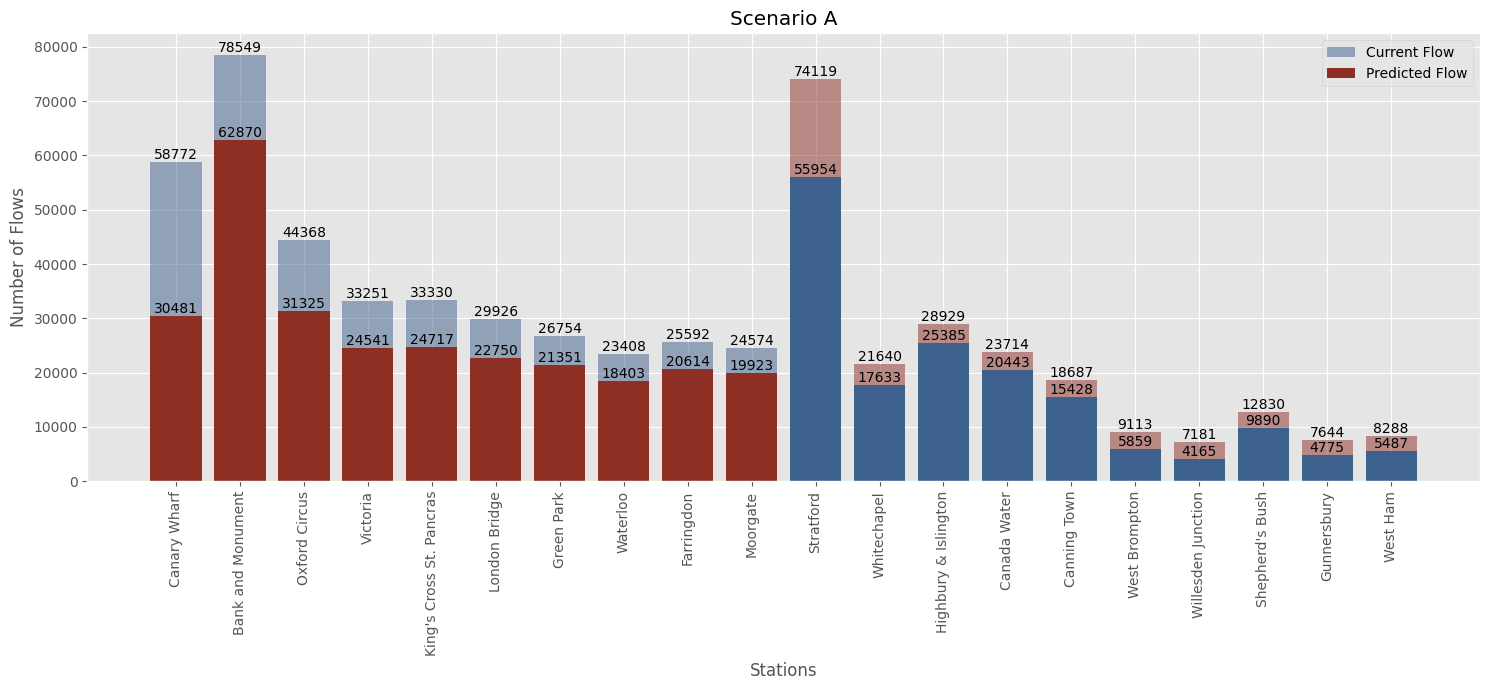

In [54]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.set_title('Scenario A')

# Plot bars for top decrease and increase
ax.bar(x=list(decrease['station_destination'][:10]), height=list(decrease['flows'][:10]), color='#3E608D', label='Current Flow',alpha=0.5)
ax.bar(x=list(decrease['station_destination'][:10]), height=list(decrease['flows_scenario_A'][:10]), color='#8D2F25', label='Predicted Flow')
ax.bar(x=list(increase['station_destination'][-10:]), height=list(increase['flows_scenario_A'][-10:]), color='#8D2F25',alpha=0.5)
ax.bar(x=list(increase['station_destination'][-10:]), height=list(increase['flows'][-10:]), color='#3E608D')

# Add annotations for exact values on top of the bars
for i in range(10):
    ax.text(i, decrease['flows'].iloc[i], str(int(decrease['flows'].iloc[i])), ha='center', va='bottom')
    ax.text(i, decrease['flows_scenario_A'].iloc[i], str(int(decrease['flows_scenario_A'].iloc[i])), ha='center', va='bottom')
    ax.text(i + 10, increase['flows_scenario_A'].iloc[-10 + i], str(int(increase['flows_scenario_A'].iloc[-10 + i])), ha='center', va='bottom')
    ax.text(i + 10, increase['flows'].iloc[-10 + i], str(int(increase['flows'].iloc[-10 + i])), ha='center', va='bottom')

plt.xlabel("Stations")
plt.ylabel("Number of Flows")
plt.xticks(rotation=90)
ax.legend(loc='upper right')
plt.tight_layout()

plt.savefig('output/scenario_A.png')
plt.show()


### IV.2. Scenario B: 


> assume that there is a significant increase in the cost of transport. Select 2 values for 
the parameter in the cost function reflecting scenario B. Recompute the distribution of flows.12


In [68]:
flows = london_flows.copy()
flows.head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,jobs_scenario_A,O_i,D_j,prodsimest1,alpha,prodsimest2,Ai1,A_i,flows_scenario_A
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,78549.0,599,78549,78.0,-2.914322,78.0,4969.549314,0.00005,148.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,442.0,599,442,1.0,-2.914322,1.0,99.375214,0.00005,3.0


In [70]:
beta

0.00015316619346263566

In [71]:
# 50% larger and 100% larger 
beta1 = beta*1.5
beta2 = beta*2

In [57]:
# beta1: 50%
flows["prodsimest_b1"] = np.exp(flows["alpha"]+gamma*flows["log_jobs"] 
                                 - beta1*flows["distance"])
flows["prodsimest_b1"] = round(flows["prodsimest_b1"],0)
matrix_b1 = flows.pivot_table(values ="prodsimest_b1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
#calculate new alpha and beta values
Dj_gamma1 = flows["jobs"]**gamma
dist_beta1 = flows["distance"]**-beta1
#calcualte the first stage of the Ai values
flows["Ai_b1"] = Dj_gamma1 * dist_beta1
# sum over all js bit
A_i_b1 = pd.DataFrame(flows.groupby(["station_origin"])["Ai_b1"].agg(np.sum))

A_i_b1["Ai_b1"] = 1/A_i_b1["Ai_b1"]
A_i_b1.rename(columns={"Ai_b1":"A_i_b1"}, inplace=True)
#and write the A_i values back into the dataframe
flows = flows.merge(A_i_b1, left_on="station_origin", right_index=True, how="left")

flows["prodsimest_b1"] = flows["A_i_b1"]*flows["O_i"]*Dj_gamma1*dist_beta1
flows["prodsimest_b1"] = round(flows["prodsimest_b1"])



C:\Users\dune\AppData\Local\Temp\ipykernel_14764\1244911339.py:5: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix_b1 = flows.pivot_table(values ="prodsimest_b1", index="station_origin", columns = "station_destination",
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\1244911339.py:5: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix_b1 = flows.pivot_table(values ="prodsimest_b1", index="station_origin", columns = "station_destination",
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\1244911339.py:5: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is cur

In [58]:

diff_b1 = flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest1':'sum','prodsimest_b1':'sum'})
diff_b1["differences_b1"]= diff_b1["flows"] - diff_b1["prodsimest_b1"]

diff_b1["diff_abs_b1"]= abs(diff_b1["differences_b1"])
diff_b1['change_b1'] = (diff_b1['flows'] / matrix.loc['All', 'All']) - (diff_b1['prodsimest_b1'] / matrix.loc['All', 'All'])

diff_b1.sort_values(by=["differences_b1"],ascending= False, inplace = True)
decrease_b1 = diff_b1[:10]

diff_b1.sort_values(by=["differences_b1"],ascending= True, inplace = True)
increase_b1 = diff_b1[:10]

name_b1 = pd.concat([decrease_b1,increase_b1])


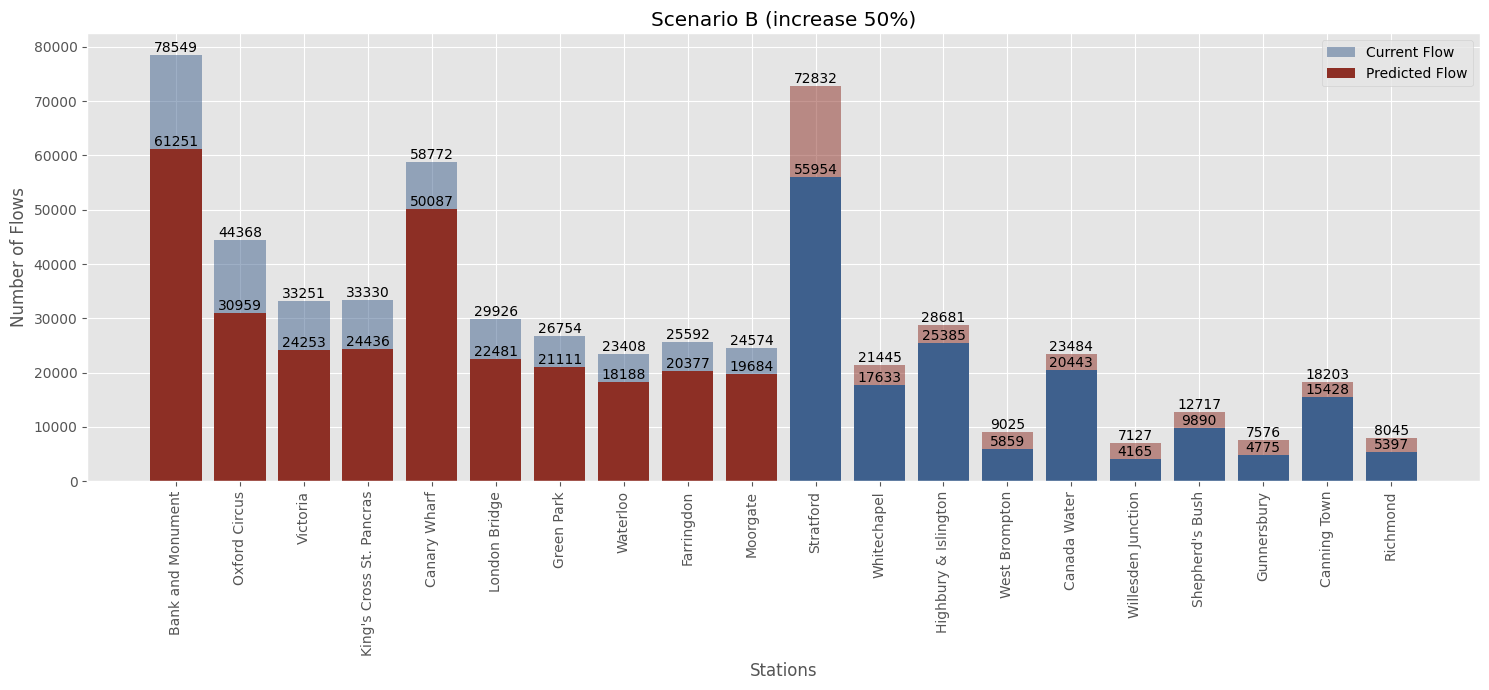

In [78]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.set_title('Scenario B (increase 50%)')

ax.bar(x=list(decrease_b1['station_destination'][:10]), height=list(decrease_b1['flows'][:10]), color='#3E608D', label='Current Flow',alpha=0.5)
ax.bar(x=list(decrease_b1['station_destination'][:10]), height=list(decrease_b1['prodsimest_b1'][:10]), color='#8D2F25', label='Predicted Flow')
ax.bar(x=list(increase_b1['station_destination'][-10:]), height=list(increase_b1['prodsimest_b1'][-10:]), color='#8D2F25',alpha=0.5)
ax.bar(x=list(increase_b1['station_destination'][-10:]), height=list(increase_b1['flows'][-10:]), color='#3E608D')

for i in range(10):
    ax.text(i, decrease_b1['flows'].iloc[i], str(int(decrease_b1['flows'].iloc[i])), ha='center', va='bottom')
    ax.text(i, decrease_b1['prodsimest_b1'].iloc[i], str(int(decrease_b1['prodsimest_b1'].iloc[i])), ha='center', va='bottom')
    ax.text(i + 10, increase_b1['prodsimest_b1'].iloc[-10 + i], str(int(increase_b1['prodsimest_b1'].iloc[-10 + i])), ha='center', va='bottom')
    ax.text(i + 10, increase_b1['flows'].iloc[-10 + i], str(int(increase_b1['flows'].iloc[-10 + i])), ha='center', va='bottom')

plt.xlabel("Stations")
plt.ylabel("Number of Flows")
plt.xticks(rotation=90)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('output/scenario_B(increase 50%).png')
plt.show()



In [74]:
# beta2: 100%
flows["prodsimest_b2"] = np.exp(flows["alpha"]+gamma*flows["log_jobs"] 
                                 - beta2*flows["distance"])
flows["prodsimest_b2"] = round(flows["prodsimest_b2"],0)


matrix_b2 = flows.pivot_table(values ="prodsimest_b2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

#calculate new alpha and beta values
Dj_gamma2 = flows["jobs"]**gamma
dist_beta2 = flows["distance"]**-beta2
#calcualte the first stage of the Ai values
flows["Ai_b2"] = Dj_gamma2 * dist_beta2
# sum over all js bit
A_i_b2 = pd.DataFrame(flows.groupby(["station_origin"])["Ai_b2"].agg(np.sum))

A_i_b2["Ai_b2"] = 1/A_i_b2["Ai_b2"]
A_i_b2.rename(columns={"Ai_b2":"A_i_b2"}, inplace=True)
#and write the A_i values back into the dataframe
flows = flows.merge(A_i_b2, left_on="station_origin", right_index=True, how="left")


C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2612668588.py:7: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix_b2 = flows.pivot_table(values ="prodsimest_b2", index="station_origin", columns = "station_destination",
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2612668588.py:7: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix_b2 = flows.pivot_table(values ="prodsimest_b2", index="station_origin", columns = "station_destination",
C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2612668588.py:7: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is cur

C:\Users\dune\AppData\Local\Temp\ipykernel_14764\2612668588.py:16: FutureWarning: The provided callable <function sum at 0x0000023E690FC220> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i_b2 = pd.DataFrame(flows.groupby(["station_origin"])["Ai_b2"].agg(np.sum))


In [75]:
flows["prodsimest_b2"] = flows["A_i_b2"]*flows["O_i"]*Dj_gamma2*dist_beta2
flows["prodsimest_b2"] = round(flows["prodsimest_b2"])

In [76]:
diff_b2 = flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest2':'sum','prodsimest_b2':'sum'})
diff_b2["differences_b2"]= diff_b2["flows"] - diff_b2["prodsimest_b2"]

diff_b2["diff_abs_b2"]= abs(diff_b2["differences_b2"])
diff_b2['change_b2'] = (diff_b2['flows'] / matrix.loc['All', 'All']) - (diff_b2['prodsimest_b2'] / matrix.loc['All', 'All'])

diff_b2.sort_values(by=["differences_b2"],ascending= False, inplace = True)
decrease_b2 = diff_b2[:10]

diff_b2.sort_values(by=["differences_b2"],ascending= True, inplace = True)
increase_b2 = diff_b2[:10]

name_b2 = pd.concat([decrease_b2,increase_b2])


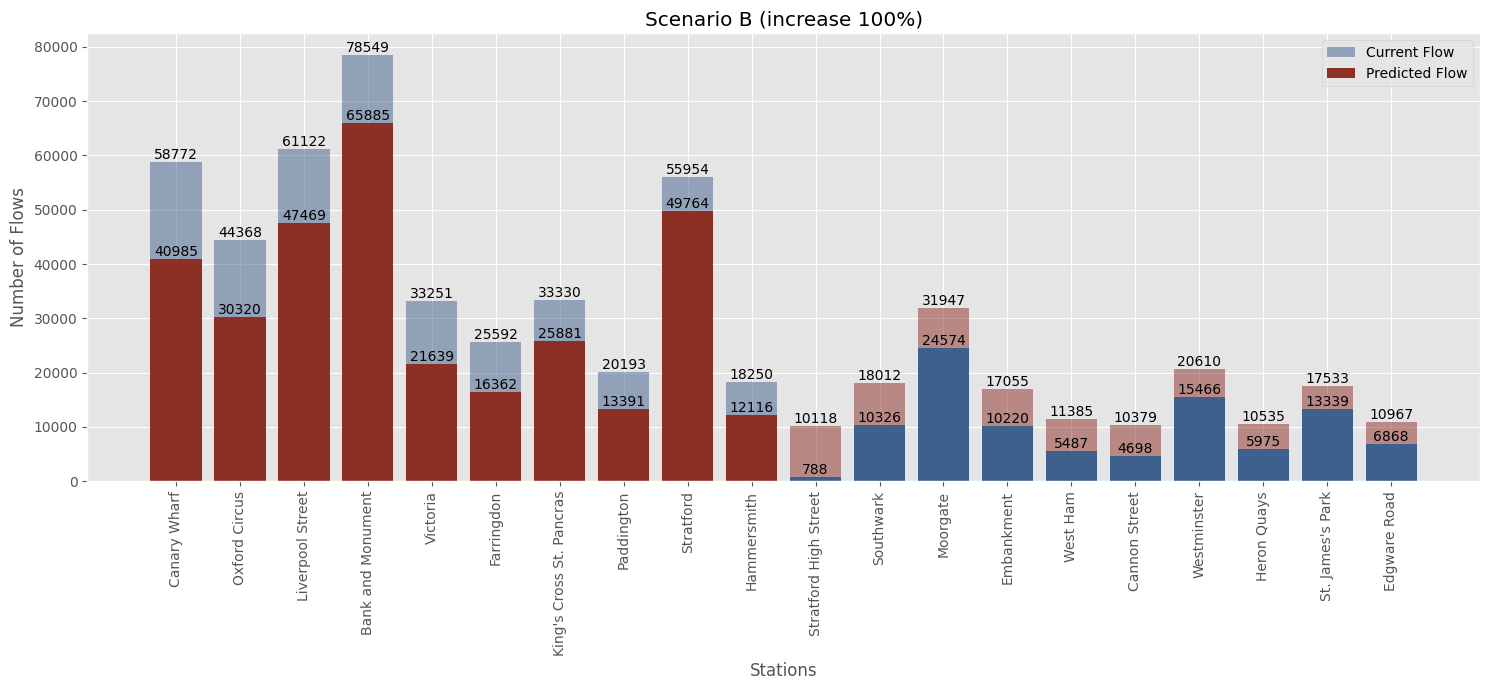

In [77]:
# plot beta2
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.set_title('Scenario B (increase 100%)')

ax.bar(x=list(decrease_b2['station_destination'][:10]), height=list(decrease_b2['flows'][:10]), color='#3E608D', label='Current Flow',alpha=0.5)
ax.bar(x=list(decrease_b2['station_destination'][:10]), height=list(decrease_b2['prodsimest_b2'][:10]), color='#8D2F25', label='Predicted Flow')
ax.bar(x=list(increase_b2['station_destination'][-10:]), height=list(increase_b2['prodsimest_b2'][-10:]), color='#8D2F25',alpha=0.5)
ax.bar(x=list(increase_b2['station_destination'][-10:]), height=list(increase_b2['flows'][-10:]), color='#3E608D')

for i in range(10):
    ax.text(i, decrease_b2['flows'].iloc[i], str(int(decrease_b2['flows'].iloc[i])), ha='center', va='bottom')
    ax.text(i, decrease_b2['prodsimest_b2'].iloc[i], str(int(decrease_b2['prodsimest_b2'].iloc[i])), ha='center', va='bottom')
    ax.text(i + 10, increase_b2['prodsimest_b2'].iloc[-10 + i], str(int(increase_b2['prodsimest_b2'].iloc[-10 + i])), ha='center', va='bottom')
    ax.text(i + 10, increase_b2['flows'].iloc[-10 + i], str(int(increase_b2['flows'].iloc[-10 + i])), ha='center', va='bottom')

plt.xlabel("Stations")
plt.ylabel("Number of Flows")
plt.xticks(rotation=90)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('output/scenario_B(increase 100%).png')
plt.show()

In [79]:
diff_b2

,station_destination,flows,prodsimest2,prodsimest_b2,differences_b2,diff_abs_b2,change_b2
327,Stratford High Street,788,655.0,10118.0,-9330.0,9330.0,-0.006049
313,Southwark,10326,12546.0,18012.0,-7686.0,7686.0,-0.004984
227,Moorgate,24574,24518.0,31947.0,-7373.0,7373.0,-0.004781
112,Embankment,10220,13101.0,17055.0,-6835.0,6835.0,-0.004432
374,West Ham,5487,7821.0,11385.0,-5898.0,5898.0,-0.003824
...,...,...,...,...,...,...,...
355,Victoria,33251,28681.0,21639.0,11612.0,11612.0,0.007529
15,Bank and Monument,78549,68371.0,65885.0,12664.0,12664.0,0.008211
212,Liverpool Street,61122,58847.0,47469.0,13653.0,13653.0,0.008852
251,Oxford Circus,44368,39723.0,30320.0,14048.0,14048.0,0.009109


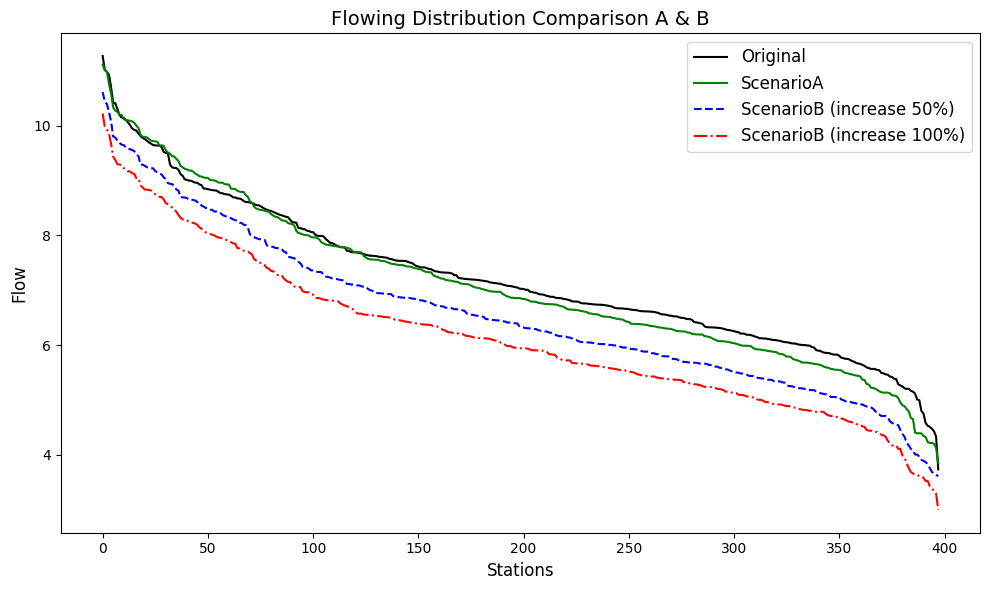

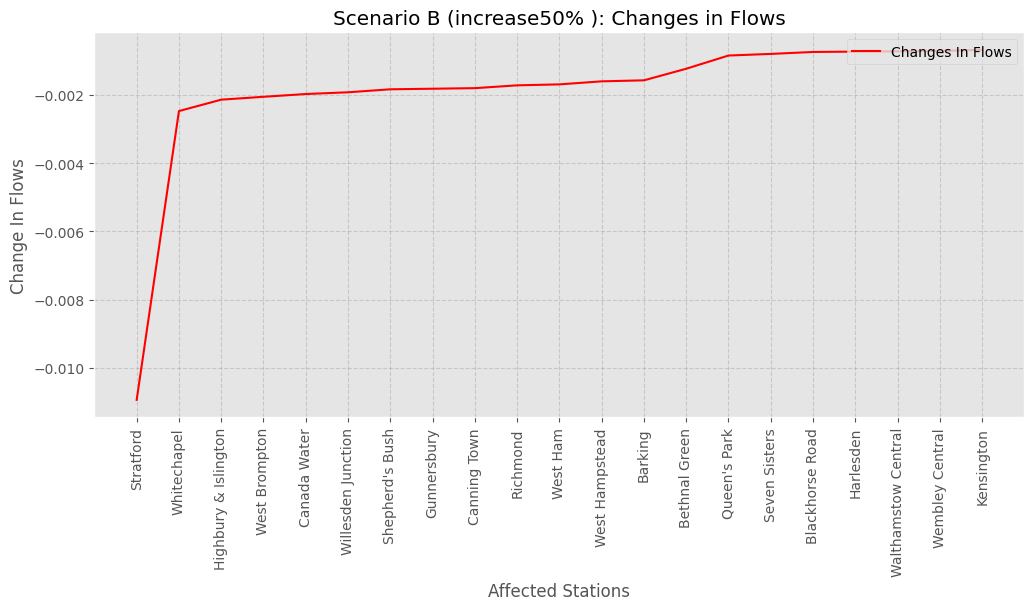

In [81]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set_title('Scenario B (increase50% ): Changes in Flows')
ax.plot(list(diff_b1['change_b1'])[:21], color = "red", label = 'Changes In Flows') 
ax.grid(color='grey', linestyle='--',alpha=0.3) 
ax.set_xlabel("Affected Stations") 
ax.set_ylabel("Change In Flows")  
ax.set_xticks(list(range(21))) 
ax.set_xticklabels(list(diff_b1['station_destination'])[:21], rotation=90)
ax.legend(loc=1)
plt.show()

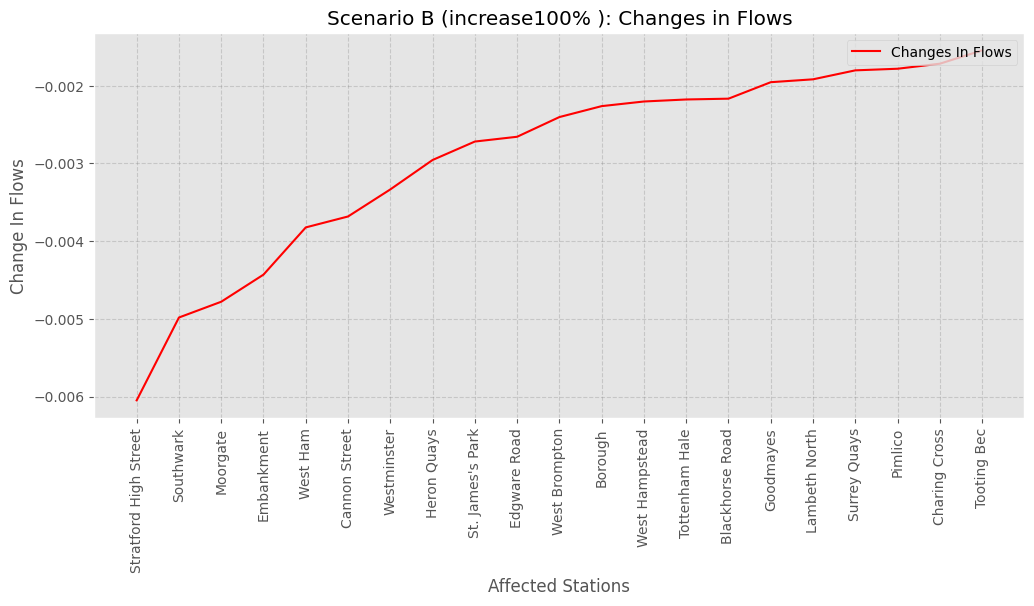

In [82]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set_title('Scenario B (increase100% ): Changes in Flows')
ax.plot(list(diff_b2['change_b2'])[:21], color = "red", label = 'Changes In Flows') 
ax.grid(color='grey', linestyle='--',alpha=0.3) 
ax.set_xlabel("Affected Stations") 
ax.set_ylabel("Change In Flows")  
ax.set_xticks(list(range(21))) 
ax.set_xticklabels(list(diff_b2['station_destination'])[:21], rotation=90)
ax.legend(loc=1)
plt.show()

### IV.3. 


> Discuss how the flows change for the 3 different situations: scenario A, and scenario B with two 
selections of parameters. Which scenario would have more impact in the redistribution of flows? 
Explain and justify your answers using the results of the analysis.10